## Libraries

In [1]:
!pip install datasets==2.15

ERROR: Could not find a version that satisfies the requirement datasets==2.15 (from versions: none)
ERROR: No matching distribution found for datasets==2.15


In [2]:
# Importing necessary libraries
import nltk
import numpy as np # linear algebra
import lightgbm as lgb
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier,GradientBoostingClassifier,BaggingClassifier
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score
import matplotlib.pyplot as plt
from sklearn.metrics import cohen_kappa_score
from lightgbm import log_evaluation, early_stopping
from sklearn.linear_model import SGDClassifier
import polars as pl
import torch
from IPython.display import display
from datasets import Dataset,DatasetDict
from transformers import AutoTokenizer
from transformers import AutoModel

nltk.download('wordnet')

[nltk_data] Error loading wordnet: <urlopen error [Errno -3] Temporary
[nltk_data]     failure in name resolution>


False

### Reading the Data

In [3]:
columns = [  
    (
        pl.col("full_text").str.split(by="\n\n").alias("paragraph")
    ),
]
PATH = "/kaggle/input/learning-agency-lab-automated-essay-scoring-2/"
# 载入训练集和测试集，同时对full_text数据使用\n\n字符分割为列表，重命名为paragraph
# Load training and testing sets, while using \ n \ n character segmentation to list and renaming to paragraph for full_text data
train = pl.read_csv(PATH + "train.csv").with_columns(columns)

# for test only
#train = train.sample(1000)
test = pl.read_csv(PATH + "test.csv").with_columns(columns)
# 显示训练集中的第一个样本数据
# Display the first sample data in the training set
train.head(1)

essay_id,full_text,score,paragraph
str,str,i64,list[str]
"""000d118""","""Many people ha…",3,"[""Many people have car where they live. The thing they don't know is that when you use a car alot of thing can happen like you can get in accidet or the smoke that the car has is bad to breath on if someone is walk but in VAUBAN,Germany they dont have that proble because 70 percent of vauban's families do not own cars,and 57 percent sold a car to move there. Street parkig ,driveways and home garages are forbidden on the outskirts of freiburd that near the French and Swiss borders. You probaly won't see a car in Vauban's streets because they are completely ""car free"" but If some that lives in VAUBAN that owns a car ownership is allowed,but there are only two places that you can park a large garages at the edge of the development,where a car owner buys a space but it not cheap to buy one they sell the space for you car for $40,000 along with a home. The vauban people completed this in 2006 ,they said that this an example of a growing trend in Europe,The untile states and some where else are suburban life from auto use this is called ""smart planning"". The current efforts to drastically reduce greenhouse gas emissions from tailes the passengee cars are responsible for 12 percent of greenhouse gas emissions in Europe and up to 50 percent in some car intensive in the United States. I honeslty think that good idea that they did that is Vaudan because that makes cities denser and better for walking and in VAUBAN there are 5,500 residents within a rectangular square mile. In the artical David Gold berg said that ""All of our development since World war 2 has been centered on the cars,and that will have to change"" and i think that was very true what David Gold said because alot thing we need cars to do we can go anyway were with out cars beacuse some people are a very lazy to walk to place thats why they alot of people use car and i think that it was a good idea that that they did that in VAUBAN so people can see how we really don't need car to go to place from place because we can walk from were we need to go or we can ride bycles with out the use of a car. It good that they are doing that if you thik about your help the earth in way and thats a very good thing to. In the United states ,the Environmental protection Agency is promoting what is called ""car reduced""communtunties,and the legislators are starting to act,if cautiously. Maany experts expect pubic transport serving suburbs to play a much larger role in a new six years federal transportation bill to approved this year. In previous bill,80 percent of appropriations have by law gone to highways and only 20 percent to other transports. There many good reason why they should do this. ""]"


### Preprocessing 

In [4]:
def removeHTML(x):
    html=re.compile(r'<.*?>')
    return html.sub(r'',x)
def dataPreprocessing(x):
    # 将单词转化为小写
    # Convert words to lowercase
    x = x.lower()
    # Remove HTML
    # 移除html
    x = removeHTML(x)
    # 删除以@作为首字母的字符串
    # Delete strings starting with @
    x = re.sub("@\w+", '',x)
    # 删除数字
    # Delete Numbers
    x = re.sub("'\d+", '',x) # can delete it
    x = re.sub("\d+", '',x)
    # 删除网址
    # Delete URL
    x = re.sub("http\w+", '',x)
    # 将连续空白符替换为一个空格字符
    # Replace consecutive empty spaces with a single space character
    x = re.sub(r"\s+", " ", x)
    # 替换连续的句号和逗号为一个
    # Replace consecutive commas and periods with one comma and period character
    x = re.sub(r"\.+", ".", x)
    x = re.sub(r"\,+", ",", x)
    # 去除开头结尾的空白符
    # Remove empty characters at the beginning and end
    x = x.strip()
    return x

### evaluation and Loss function

In [5]:
# evaluation metric.
# idea from https://www.kaggle.com/code/rsakata/optimize-qwk-by-lgb/notebook#QWK-objective
def quadratic_weighted_kappa(y_true, y_pred):
    y_true = y_true + a
    y_pred = (y_pred + a).clip(1, 6).round()
    qwk = cohen_kappa_score(y_true, y_pred, weights="quadratic")
    return 'QWK', qwk, True

# Loss function
def qwk_obj(y_true, y_pred):
    labels = y_true + a
    preds = y_pred + a
    preds = preds.clip(1, 6)
    f = 1/2*np.sum((preds-labels)**2)
    g = 1/2*np.sum((preds-a)**2+b)
    df = preds - labels
    dg = preds - a
    grad = (df/g - f*dg/g**2)*len(labels)
    hess = np.ones(len(labels))
    return grad, hess
a = 2.948
b = 1.092

### Feature extraction

In [6]:
# convert the df to dataset 
train = train.with_columns(pl.col('full_text').map_elements(dataPreprocessing,return_dtype=str))
test = test.with_columns(pl.col('full_text').map_elements(dataPreprocessing,return_dtype=str))

ds_train = Dataset.from_pandas(train.to_pandas())
ds_test = Dataset.from_pandas(test.to_pandas())

ds = DatasetDict({"train": ds_train, "test": ds_test})

# Print the dataset dictionary keys and sizes
for name, dataset in ds.items():
    print(f"{name} size:", len(dataset))


train size: 17307
test size: 3


In [7]:
# tokenize 
model_ckpt = "/kaggle/input/es-deberta-large-fold0"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

def tokenize(batch):
    return tokenizer(batch["full_text"], padding=True)

dst = ds.map(tokenize, batched=True ,batch_size = 64)
print(dst)

Map:   0%|          | 0/17307 [00:00<?, ? examples/s]

Map:   0%|          | 0/3 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['essay_id', 'full_text', 'score', 'paragraph', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 17307
    })
    test: Dataset({
        features: ['essay_id', 'full_text', 'paragraph', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 3
    })
})


In [8]:
# load the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)

In [9]:
# set format to tensors, ( needed for the model Feedforward )
dst.set_format("torch",columns=["input_ids", "attention_mask"])

# remove unwanted features
columns_to_remove = ['essay_id', 'full_text', 'paragraph']
dstr = dst.remove_columns(columns_to_remove)

In [10]:
# extract the features
def extract_hidden_states(batch):
    # Place model inputs on the GPU
    inputs = {k:v.to(device) for k,v in batch.items() 
              if k in tokenizer.model_input_names}
    # Extract last hidden states
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
    # Return vector for [CLS] token
    return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}

# prepare the vectors
dstr_hidden = dstr.map(extract_hidden_states,batched=True,batch_size = 2)

Map:   0%|          | 0/17307 [00:00<?, ? examples/s]

Map:   0%|          | 0/3 [00:00<?, ? examples/s]

### modeling

In [11]:
X = dstr_hidden['train']['hidden_state'].numpy()
y_split = np.array(dstr_hidden['train']['score'])
y = y_split-a

fold 1


1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.


[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 75 rounds
[25]	train's QWK: 0.865971	valid's QWK: 0.864248
[50]	train's QWK: 0.869144	valid's QWK: 0.864249
[75]	train's QWK: 0.870503	valid's QWK: 0.86389
[100]	train's QWK: 0.872325	valid's QWK: 0.863997
Early stopping, best iteration is:
[49]	train's QWK: 0.869108	valid's QWK: 0.864799
Evaluated only: QWK


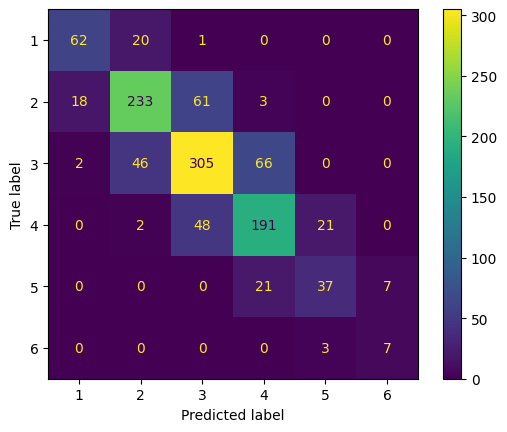

F1 score across fold: 0.7239677098033429
Cohen kappa score across fold: 0.8647985446327869
fold 2
[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 75 rounds
[25]	train's QWK: 0.864487	valid's QWK: 0.865129
[50]	train's QWK: 0.867988	valid's QWK: 0.868643
[75]	train's QWK: 0.870459	valid's QWK: 0.866917
[100]	train's QWK: 0.871878	valid's QWK: 0.867488
[125]	train's QWK: 0.873061	valid's QWK: 0.870209
[150]	train's QWK: 0.874669	valid's QWK: 0.870219
[175]	train's QWK: 0.875757	valid's QWK: 0.868659
[200]	train's QWK: 0.876531	valid's QWK: 0.867639
[225]	train's QWK: 0.877956	valid's QWK: 0.867417
Early stopping, best iteration is:
[156]	train's QWK: 0.874841	valid's QWK: 0.871388
Evaluated only: QWK


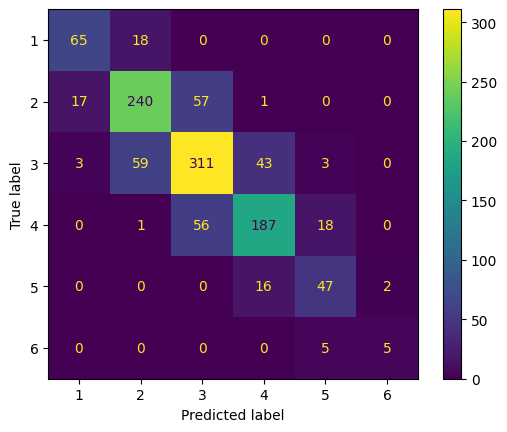

F1 score across fold: 0.7408255354152243
Cohen kappa score across fold: 0.8713881817435272
fold 3
[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 75 rounds
[25]	train's QWK: 0.865605	valid's QWK: 0.860974
[50]	train's QWK: 0.868982	valid's QWK: 0.85767
[75]	train's QWK: 0.871321	valid's QWK: 0.85982
Early stopping, best iteration is:
[15]	train's QWK: 0.86104	valid's QWK: 0.862159
Evaluated only: QWK


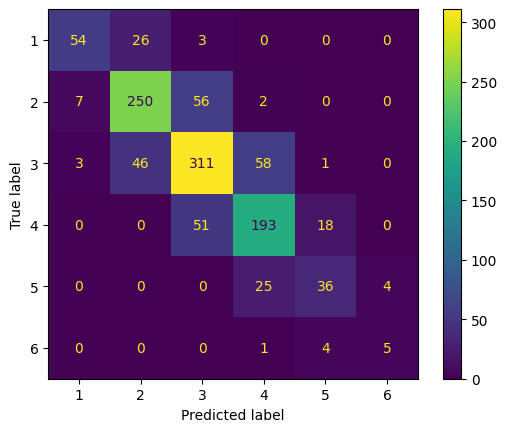

F1 score across fold: 0.7352099317750186
Cohen kappa score across fold: 0.862159284664485
fold 4
[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 75 rounds
[25]	train's QWK: 0.86536	valid's QWK: 0.868317
[50]	train's QWK: 0.869026	valid's QWK: 0.866134
[75]	train's QWK: 0.870038	valid's QWK: 0.86954
[100]	train's QWK: 0.871096	valid's QWK: 0.868089
[125]	train's QWK: 0.872806	valid's QWK: 0.871131
[150]	train's QWK: 0.874114	valid's QWK: 0.870139
[175]	train's QWK: 0.87579	valid's QWK: 0.870274
Early stopping, best iteration is:
[122]	train's QWK: 0.87313	valid's QWK: 0.871926
Evaluated only: QWK


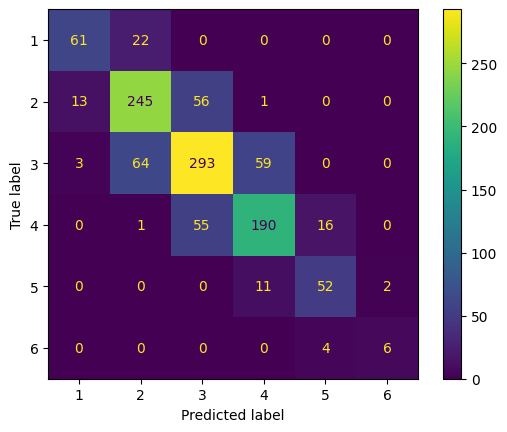

F1 score across fold: 0.7335904128169382
Cohen kappa score across fold: 0.8719260042035546
fold 5
[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 75 rounds
[25]	train's QWK: 0.86646	valid's QWK: 0.849053
[50]	train's QWK: 0.869739	valid's QWK: 0.853941
[75]	train's QWK: 0.871503	valid's QWK: 0.853284
[100]	train's QWK: 0.872756	valid's QWK: 0.855671
[125]	train's QWK: 0.874538	valid's QWK: 0.855442
[150]	train's QWK: 0.876304	valid's QWK: 0.853558
[175]	train's QWK: 0.877391	valid's QWK: 0.853228
[200]	train's QWK: 0.878617	valid's QWK: 0.854688
[225]	train's QWK: 0.879502	valid's QWK: 0.85535
[250]	train's QWK: 0.880345	valid's QWK: 0.854027
[275]	train's QWK: 0.881727	valid's QWK: 0.854448
Early stopping, best iteration is:
[208]	train's QWK: 0.878914	valid's QWK: 0.857044
Evaluated only: QWK


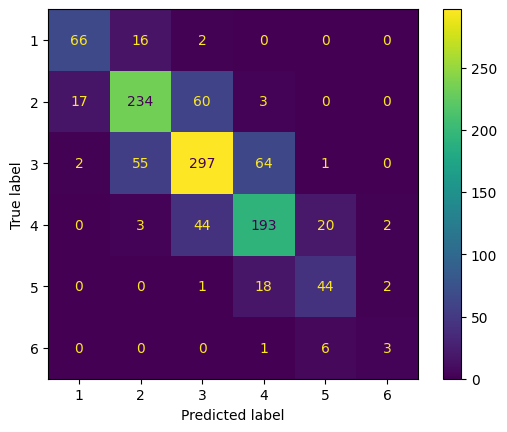

F1 score across fold: 0.7251328987772396
Cohen kappa score across fold: 0.8570444976155147
fold 6
[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 75 rounds
[25]	train's QWK: 0.865704	valid's QWK: 0.865924
[50]	train's QWK: 0.868692	valid's QWK: 0.864343
[75]	train's QWK: 0.870703	valid's QWK: 0.861526
[100]	train's QWK: 0.872613	valid's QWK: 0.861436
Early stopping, best iteration is:
[30]	train's QWK: 0.866216	valid's QWK: 0.866797
Evaluated only: QWK


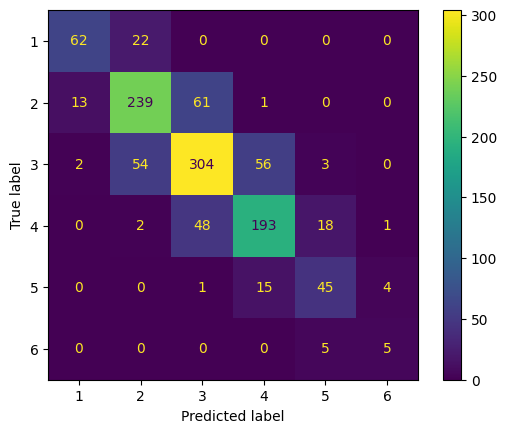

F1 score across fold: 0.7350954286142405
Cohen kappa score across fold: 0.8667969345815968
fold 7
[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 75 rounds
[25]	train's QWK: 0.865936	valid's QWK: 0.858442
[50]	train's QWK: 0.869038	valid's QWK: 0.859317
[75]	train's QWK: 0.870482	valid's QWK: 0.860079
[100]	train's QWK: 0.871851	valid's QWK: 0.85865
[125]	train's QWK: 0.873487	valid's QWK: 0.859083
Early stopping, best iteration is:
[61]	train's QWK: 0.870043	valid's QWK: 0.861772
Evaluated only: QWK


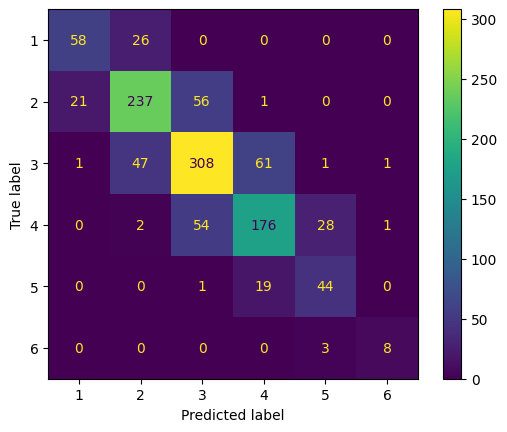

F1 score across fold: 0.7205521686367458
Cohen kappa score across fold: 0.861771669807539
fold 8
[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 75 rounds
[25]	train's QWK: 0.865824	valid's QWK: 0.859204
[50]	train's QWK: 0.869111	valid's QWK: 0.865224
[75]	train's QWK: 0.870607	valid's QWK: 0.864299
[100]	train's QWK: 0.871101	valid's QWK: 0.862951
Early stopping, best iteration is:
[49]	train's QWK: 0.868919	valid's QWK: 0.865577
Evaluated only: QWK


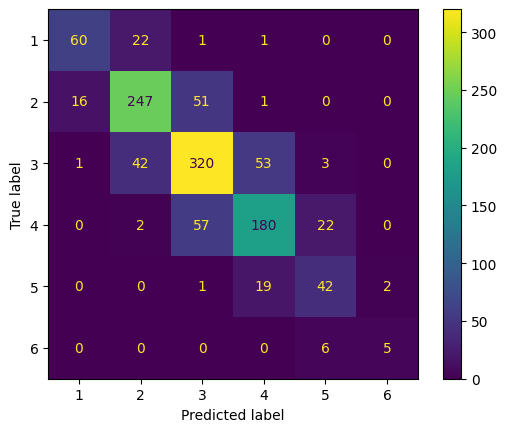

F1 score across fold: 0.7400761305371518
Cohen kappa score across fold: 0.8655772088711601
fold 9
[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 75 rounds
[25]	train's QWK: 0.866595	valid's QWK: 0.849554
[50]	train's QWK: 0.869226	valid's QWK: 0.850498
[75]	train's QWK: 0.871183	valid's QWK: 0.850653
[100]	train's QWK: 0.87332	valid's QWK: 0.847854
Early stopping, best iteration is:
[45]	train's QWK: 0.868503	valid's QWK: 0.852423
Evaluated only: QWK


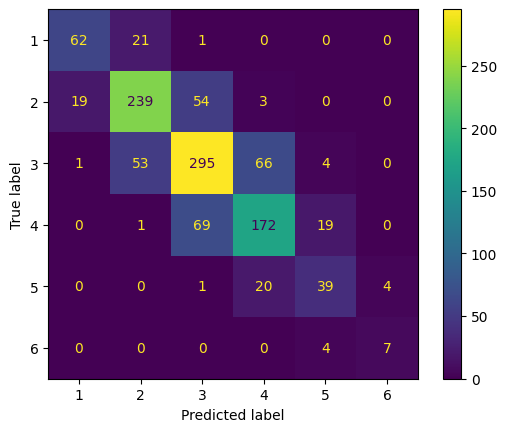

F1 score across fold: 0.7055245642087538
Cohen kappa score across fold: 0.8524234950139505
fold 10
[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 75 rounds
[25]	train's QWK: 0.864597	valid's QWK: 0.873755
[50]	train's QWK: 0.867958	valid's QWK: 0.875933
[75]	train's QWK: 0.870213	valid's QWK: 0.87521
[100]	train's QWK: 0.871662	valid's QWK: 0.875639
Early stopping, best iteration is:
[33]	train's QWK: 0.866109	valid's QWK: 0.877029
Evaluated only: QWK


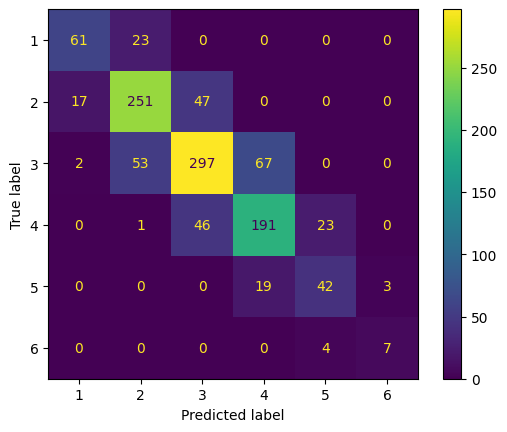

F1 score across fold: 0.7358177820621257
Cohen kappa score across fold: 0.8770293136085758
fold 11
[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 75 rounds
[25]	train's QWK: 0.865473	valid's QWK: 0.864455
[50]	train's QWK: 0.867928	valid's QWK: 0.867717
[75]	train's QWK: 0.87049	valid's QWK: 0.868455
[100]	train's QWK: 0.871788	valid's QWK: 0.869573
[125]	train's QWK: 0.873645	valid's QWK: 0.870132
[150]	train's QWK: 0.875158	valid's QWK: 0.868148
[175]	train's QWK: 0.876372	valid's QWK: 0.871196
[200]	train's QWK: 0.877698	valid's QWK: 0.868314
[225]	train's QWK: 0.879048	valid's QWK: 0.868838
Early stopping, best iteration is:
[174]	train's QWK: 0.876293	valid's QWK: 0.871196
Evaluated only: QWK


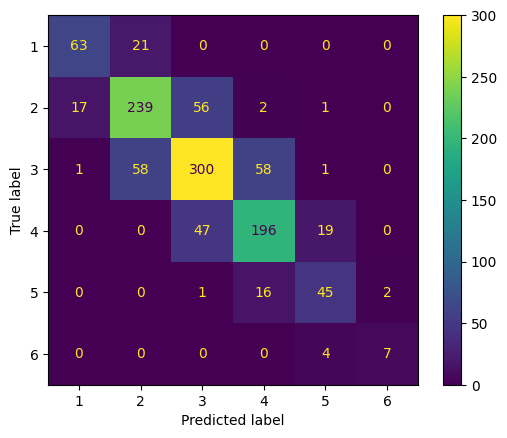

F1 score across fold: 0.736687092562041
Cohen kappa score across fold: 0.8711957734950517
fold 12
[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 75 rounds
[25]	train's QWK: 0.86488	valid's QWK: 0.861417
[50]	train's QWK: 0.868637	valid's QWK: 0.862469
[75]	train's QWK: 0.870118	valid's QWK: 0.86183
[100]	train's QWK: 0.871981	valid's QWK: 0.862044
[125]	train's QWK: 0.874015	valid's QWK: 0.86169
Early stopping, best iteration is:
[51]	train's QWK: 0.868675	valid's QWK: 0.862803
Evaluated only: QWK


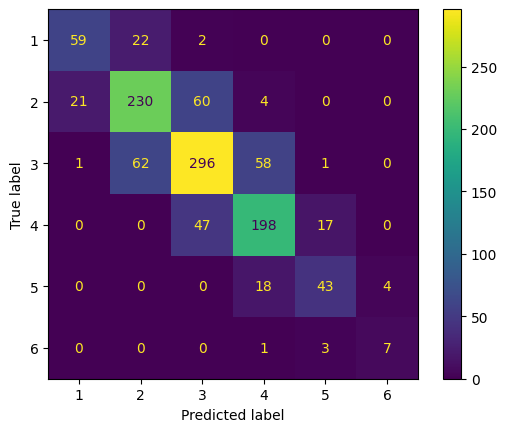

F1 score across fold: 0.721726404681425
Cohen kappa score across fold: 0.8628034031993135
fold 13
[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 75 rounds
[25]	train's QWK: 0.865118	valid's QWK: 0.862805
[50]	train's QWK: 0.868208	valid's QWK: 0.864784
[75]	train's QWK: 0.869626	valid's QWK: 0.863515
[100]	train's QWK: 0.871681	valid's QWK: 0.863527
[125]	train's QWK: 0.873497	valid's QWK: 0.863861
Early stopping, best iteration is:
[67]	train's QWK: 0.869468	valid's QWK: 0.865413
Evaluated only: QWK


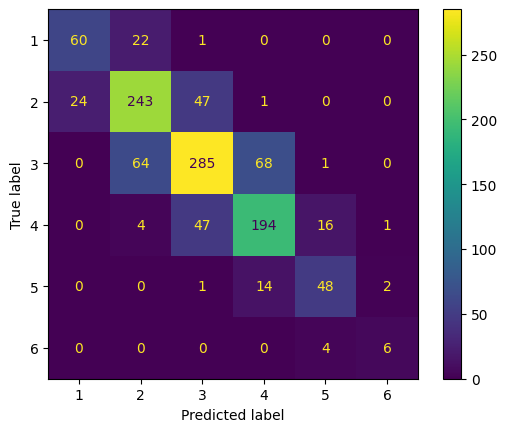

F1 score across fold: 0.7246943040521983
Cohen kappa score across fold: 0.8654127010842124
fold 14
[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 75 rounds
[25]	train's QWK: 0.865112	valid's QWK: 0.863216
[50]	train's QWK: 0.867616	valid's QWK: 0.866195
[75]	train's QWK: 0.869633	valid's QWK: 0.865764
[100]	train's QWK: 0.870757	valid's QWK: 0.867601
[125]	train's QWK: 0.872084	valid's QWK: 0.865186
[150]	train's QWK: 0.873637	valid's QWK: 0.863588
Early stopping, best iteration is:
[93]	train's QWK: 0.870486	valid's QWK: 0.868051
Evaluated only: QWK


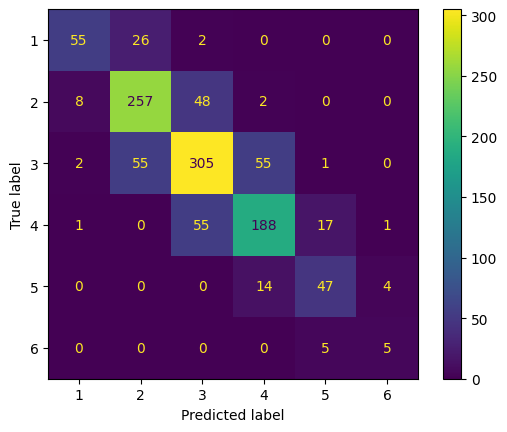

F1 score across fold: 0.7428549463623679
Cohen kappa score across fold: 0.8680507387656954
fold 15
[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 75 rounds
[25]	train's QWK: 0.863308	valid's QWK: 0.873151
[50]	train's QWK: 0.866842	valid's QWK: 0.87408
[75]	train's QWK: 0.868722	valid's QWK: 0.872847
[100]	train's QWK: 0.870766	valid's QWK: 0.872277
Early stopping, best iteration is:
[47]	train's QWK: 0.866968	valid's QWK: 0.874217
Evaluated only: QWK


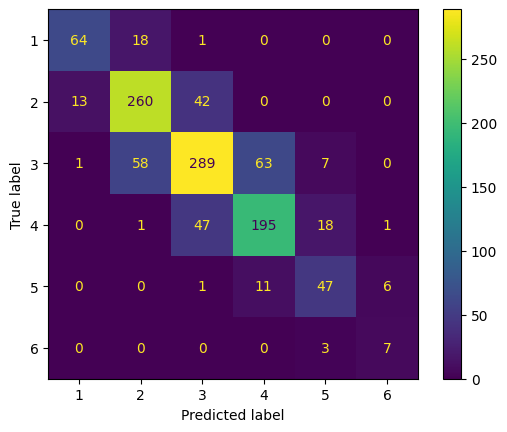

F1 score across fold: 0.7475126151552046
Cohen kappa score across fold: 0.8742174684560347
Mean F1 score across 15 folds: 0.7312845283640013
Mean Cohen kappa score across 15 folds: 0.8661730146495332


In [12]:
# Define the number of splits for cross-validation
n_splits = 15

# Initialize StratifiedKFold with the specified number of splits
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=0)

# Lists to store scores
f1_scores = []
kappa_scores = []
models = []
predictions = []
callbacks = [log_evaluation(period=25), early_stopping(stopping_rounds=75,first_metric_only=True)]
# Loop through each fold of the cross-validation
i=1
for train_index, test_index in skf.split(X, y_split):
    # Split the data into training and testing sets for this fold
    print('fold',i)
    X_train_fold, X_test_fold = X[train_index], X[test_index]
    y_train_fold, y_test_fold, y_test_fold_int = y[train_index], y[test_index], y_split[test_index]
    
    model = lgb.LGBMRegressor(
                objective = qwk_obj,
                metrics = 'None',
                learning_rate = 0.1,
                max_depth = 5,
                num_leaves = 10,
                colsample_bytree=0.5,
                reg_alpha = 0.1,
                reg_lambda = 0.8,
                n_estimators=1024,
                random_state=42,
                extra_trees=True,
                class_weight='balanced',
                device='gpu',
                verbosity = - 1)

    # Fit the model on the training data for this fold
    
    predictor = model.fit(X_train_fold,
                                  y_train_fold,
                                  eval_names=['train', 'valid'],
                                  eval_set=[(X_train_fold, y_train_fold), (X_test_fold, y_test_fold)],
                                  eval_metric=quadratic_weighted_kappa,
                                  callbacks=callbacks,)
    models.append(predictor)
    # Make predictions on the test data for this fold
    predictions_fold = predictor.predict(X_test_fold)
    predictions_fold = predictions_fold + a
    predictions_fold = predictions_fold.clip(1, 6).round()
    predictions.append(predictions_fold)
    # Calculate and store the F1 score for this fold
    f1_fold = f1_score(y_test_fold_int, predictions_fold, average='weighted')
    f1_scores.append(f1_fold)
    
    # Calculate and store the Cohen's kappa score for this fold
    kappa_fold = cohen_kappa_score(y_test_fold_int, predictions_fold, weights='quadratic')
    kappa_scores.append(kappa_fold)
    
    # Calculating the confusion matrix
    cm = confusion_matrix(y_test_fold_int, predictions_fold, labels=[x for x in range(1,7)])

    # Displaying the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=[x for x in range(1,7)])
    disp.plot()
    plt.show()
    print(f'F1 score across fold: {f1_fold}')
    print(f'Cohen kappa score across fold: {kappa_fold}')
    i+=1
# Calculate the mean scores across all folds
mean_f1_score = np.mean(f1_scores)
mean_kappa_score = np.mean(kappa_scores)

# Print the mean scores
print(f'Mean F1 score across {n_splits} folds: {mean_f1_score}')
print(f'Mean Cohen kappa score across {n_splits} folds: {mean_kappa_score}')

### Inference

In [13]:
probabilities = []
for model in models:
    proba= model.predict(dstr_hidden['test']['hidden_state'].numpy())+ a
    probabilities.append(proba)
# Compute the average probabilities across all models
predictions = np.mean(probabilities, axis=0)

predictions = np.round(predictions.clip(1, 6))

# Print the predictions
print(predictions)


[3. 3. 4.]


In [14]:
submission=pd.read_csv("/kaggle/input/learning-agency-lab-automated-essay-scoring-2/sample_submission.csv")
submission['score']=predictions
submission['score']=submission['score'].astype(int)
submission.to_csv("submission.csv",index=None)
display(submission.head())

,essay_id,score
0,000d118,3
1,000fe60,3
2,001ab80,4
